## MargFormer - Experiment3 - Star-Galaxy Classification

## Star-Galaxy Classification (Experiment 3) using Vision Transformer (ViT, Linformer) Model with CLS token derived uisng the Photometric Features. Query is defined using only photometry data in the Cross-Attention.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.proportion import proportion_confint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from linformer import LinformerCA
from vit_pytorch.efficient_new import ViT


In [2]:
dnnx_sg = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/dnnx_sg_exp3.npy")
X_sg = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/X_sg_exp3.npy")
X_sg = X_sg.transpose((0, 3, 1, 2))

y_sg = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/y_sg_exp3.npy")
y_sg = np.argmax(y_sg, axis=1)
print(X_sg.shape)


(19022, 5, 32, 32)


In [3]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


In [4]:
# Initialize the PyTorch model
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_sg.shape[1]

PATCH_SIZE = 4
DEPTH = 12
HIDDEN_DIM = 64
K_DIM = 64
NUM_HEADS = 8

LR = 1e-3
STEP_SIZE = 5
GAMMA = 0.9

LIN_DROPOUT = 0.1

seq_len = int((32/PATCH_SIZE)**2) + 1

## Linformer
lin = LinformerCA(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=32, patch_size=PATCH_SIZE, num_classes=n_classes, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=in_channels).to(device)


cuda:0


In [5]:
# Load the saved model state dictionary
model.load_state_dict(torch.load('./Trained_Models/Experiment1/SG/EX1_SG_MargFormer_Model.pth', map_location=device))

# Set the model to evaluation mode
model.eval()


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=80, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (to_dnn): Sequential(
    (0): Linear(in_features=24, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=64, bias=True)
  )
  (transformer): LinformerCA(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerCrossAttention(
              (to_q): Linear(in_features=64, out_features=64, bia

In [6]:
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

In [7]:
test_dataset = SGData(dnnx_sg, X_sg, y_sg, transform=None)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)


In [8]:
label_strings = ['GALAXY', 'STAR']
y_test_pred = torch.empty(0).to(device)
print('\n')
# Generate predictions
with torch.no_grad():
    for pf, images, labels in test_loader:
        pf = pf.to(device)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(pf, images)

        y_test_pred = torch.cat((y_test_pred, pred), dim=0)

y_test_pred = y_test_pred.cpu().numpy()
y_test_pred = y_test_pred.argmax(axis=1)
print(get_metrics(y_test_pred, y_sg, label_strings))





Identified 17731 correct labels out of 19022 labels
Accuracy: 0.9321312164861739
Precision: 0.9365324141834817
Recall: 0.9321312164861739
F1 Score: 0.9319597179198099
Labels are: ['GALAXY', 'STAR']
Confusion Matrix:
 [[9343  168]
 [1123 8388]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94      9511
           1       0.98      0.88      0.93      9511

    accuracy                           0.93     19022
   macro avg       0.94      0.93      0.93     19022
weighted avg       0.94      0.93      0.93     19022

(array([    0,     1,     2, ..., 19019, 19020, 19021]), 0.9321312164861739, 0.9365324141834817, 0.9321312164861739, array([[9343,  168],
       [1123, 8388]]), '              precision    recall  f1-score   support\n\n           0       0.89      0.98      0.94      9511\n           1       0.98      0.88      0.93      9511\n\n    accuracy                           0.93     19022\n   macro avg     

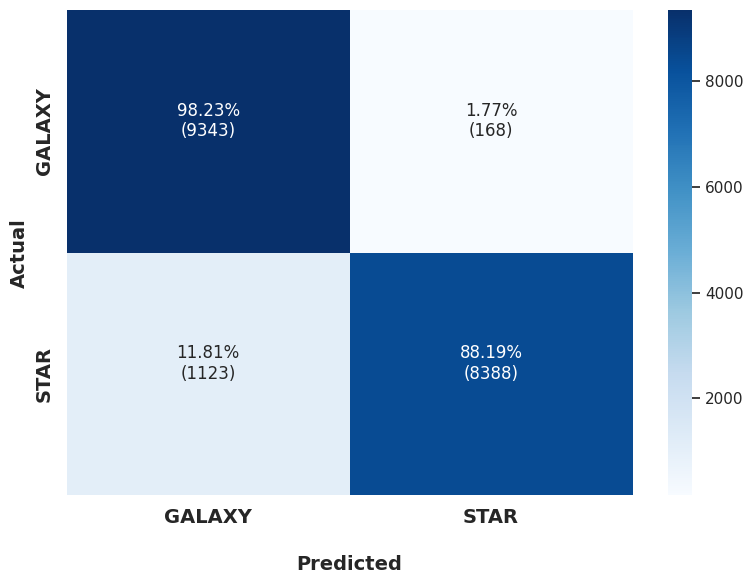

In [9]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_sg, y_test_pred)
cf_matrix_percentage = metrics.confusion_matrix(y_sg, y_test_pred, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("Trained_Models/Experiment3/SG/EX3_SG_MargFormer_CM.png")
# plt.close()


## Result Analysis

In [10]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

idx_drop = np.where(y=="QSO")[0]
X = np.delete(X,idx_drop,axis=0)
dnnx = np.delete(dnnx,idx_drop,axis=0)
y = np.delete(y,idx_drop,axis=0)
objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)

zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)


class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        
        if self.transform:
            inputs_pf = inputs_pf
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# Create DataLoader for training and validation data
test_ex1_dataset = SGData(dnnx_test, X_test, y_test, transform=None)
test_ex1_loader = DataLoader(test_ex1_dataset, batch_size=512, shuffle=False, num_workers=4)

test_ex3_dataset = SGData(dnnx_sg, X_sg, y_sg, transform=None)
test_ex3_loader = DataLoader(test_ex3_dataset, batch_size=512, shuffle=False, num_workers=4)




['GALAXY' 'STAR']


The shape of the Train data is: (120007, 5, 32, 32)
The shape of the Validation data is: (19992, 5, 32, 32)
The shape of the Test data is: (20000, 5, 32, 32)


In [11]:
# model.load_state_dict(torch.load('./Trained_Models/Experiment1/SG/EX1_SG_MargFormer_Model.pth', map_location=device))
# model.eval()

def get_preds(loader):
    model.eval()
    all_logits = []

    with torch.no_grad():
        for pf, images, labels in loader:
            pf = pf.to(device)
            images = images.to(device)
            logits = model(pf, images)      # [batch, 3]
            all_logits.append(logits.cpu())

    all_logits = torch.cat(all_logits, dim=0)   # [N, 3]
    all_probs  = F.softmax(all_logits, dim=1)   # probabilities, rows sum to 1
    all_probs  = all_probs.numpy()

    pred_labels = all_probs.argmax(axis=1)
    return all_probs, pred_labels

preds_test_ex1, y_test_ex1_pred = get_preds(test_ex1_loader)
print(get_metrics(y_test_ex1_pred, y_test, label_strings))
print('\n')

preds_test_ex3, y_test_ex3_pred = get_preds(test_ex3_loader)
print(get_metrics(y_test_ex3_pred, y_sg, label_strings))


Identified 19627 correct labels out of 20000 labels
Accuracy: 0.98135
Precision: 0.9813872292455335
Recall: 0.981332075219314
F1 Score: 0.9813486365387025
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9728  220]
 [ 153 9899]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.98      0.98      0.98     10052

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

(array([    0,     1,     2, ..., 19997, 19998, 19999]), 0.98135, 0.9813872292455335, 0.981332075219314, array([[9728,  220],
       [ 153, 9899]]), '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      9948\n           1       0.98      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98 

In [12]:
# True labels as strings
label_strings_list = [str(x) for x in label_strings]
true_labels_str = [label_strings_list[i] for i in y_test]

# Predicted labels (argmax) as strings
pred_idx = preds_test_ex1.argmax(axis=1)
pred_labels_str = [label_strings_list[i] for i in pred_idx]

# Build DataFrame
data = {}

# String labels instead of 0/1
data["true_label"] = true_labels_str
# data["pred_label"] = pred_labels_str  # optional but useful

# Probability columns with class names instead of 0,1,...
for i, name in enumerate(label_strings_list):
    # if you prefer lowercase column names, use name.lower() here
    col_name = f"{name}"
    data[col_name] = preds_test_ex1[:, i]

df = pd.DataFrame(data)
d_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(d_shuffled)
split_idx = n // 2   # if n is odd, one part will have 1 extra row

# Split into calibration and test
calibration_data = d_shuffled.iloc[:split_idx].copy()
# test_data  = d_shuffled.iloc[split_idx:].copy()

# Save to CSV
# df.to_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_test_predictions.csv", index=False)
# print("Saved to test_predictions_with_names.csv")


In [13]:
# True labels as strings
label_strings_list1 = [str(x) for x in label_strings]
true_labels_str1 = [label_strings_list1[i] for i in y_sg]

# Predicted labels (argmax) as strings
pred_idx1 = preds_test_ex3.argmax(axis=1)
pred_labels_str1 = [label_strings_list1[i] for i in pred_idx1]

# Build DataFrame
data1 = {}

# String labels instead of 0/1
data1["true_label"] = true_labels_str1
# data["pred_label"] = pred_labels_str  # optional but useful

# Probability columns with class names instead of 0,1,...
for i, name in enumerate(label_strings_list1):
    # if you prefer lowercase column names, use name.lower() here
    col_name = f"{name}"
    data1[col_name] = preds_test_ex3[:, i]

df1 = pd.DataFrame(data1)
d_shuffled1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

test_data  = d_shuffled1.copy()

# Save to CSV
# df.to_csv("Trained_Models/Experiment2/SG/EX2_SG_MargFormer_test_predictions.csv", index=False)
# print("Saved to test_predictions_with_names.csv")


CP mode:          mondrian
Example alpha:    0.32
True label:        STAR
Argmax prediction: STAR
CP prediction set: []
Set size:          0
------------------------------------------------------------
q_hat thresholds at alpha = 0.32:
  GALAXY: 0.001720
  STAR: 0.003058
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.32:
  Set size 0: 10553 / 19022 (55.48% of test points)
  Set size 1: 8469 / 19022 (44.52% of test points)

Examples with prediction set size = 0:
  Test index 0: true_label=STAR, argmax_pred=STAR, pred_set=[]
  Test index 1: true_label=GALAXY, argmax_pred=GALAXY, pred_set=[]

Examples with prediction set size = 1:
  Test index 2: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
  Test index 3: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


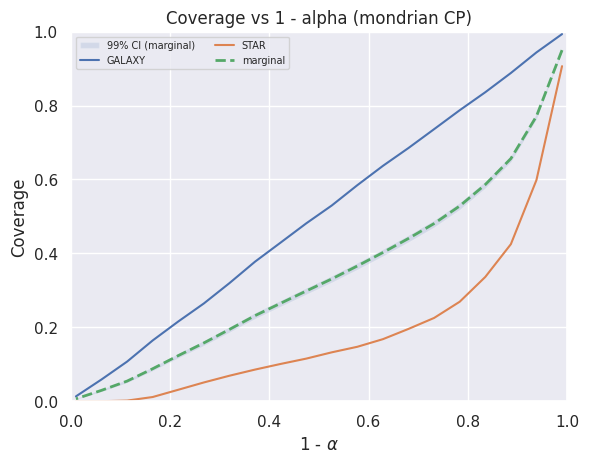

Generating set-size plot...


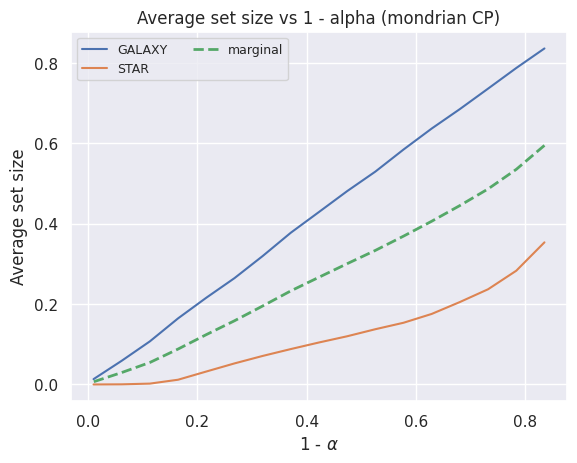

Generating ROC-style plot...


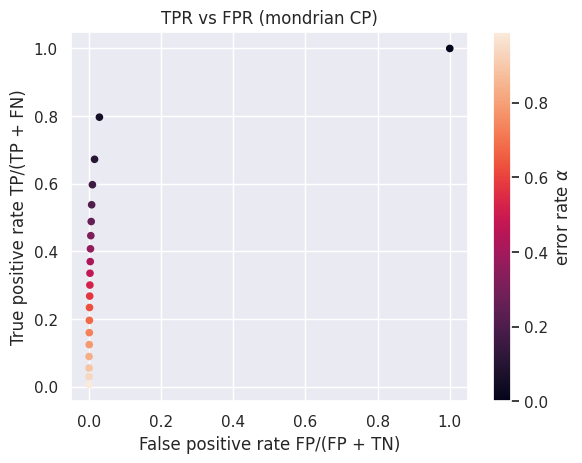

{'coverage_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_68/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_68/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_68/roc_mondrian.png'}

In [14]:
from conformal_cp import ConformalCPAnalysis

analyzer = ConformalCPAnalysis(cp_mode="mondrian", nonconf_type="baseline")
analyzer.fit(calibration_data, test_data)

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.32,
    cutoff=3,
    save_dir="Trained_Models/Experiment3/SG/MargFormer/cp_plots_68",
    show_plots=True,
)


In [15]:
print(test_data.loc[0])
print('\n')
print(test_data.loc[1])
print('\n')
print(test_data.loc[2])
print('\n')
print(test_data.loc[3])


true_label        STAR
GALAXY        0.011914
STAR          0.988086
Name: 0, dtype: object


true_label      GALAXY
GALAXY        0.989331
STAR          0.010669
Name: 1, dtype: object


true_label      GALAXY
GALAXY        0.999533
STAR          0.000467
Name: 2, dtype: object


true_label      GALAXY
GALAXY        0.999814
STAR          0.000186
Name: 3, dtype: object


CP mode:          mondrian
Example alpha:    0.1
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.1:
  GALAXY: 0.027533
  STAR: 0.020466
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.1:
  Set size 0: 5756 / 19022 (30.26% of test points)
  Set size 1: 13266 / 19022 (69.74% of test points)

Examples with prediction set size = 0:
  Test index 4: true_label=STAR, argmax_pred=GALAXY, pred_set=[]
  Test index 5: true_label=GALAXY, argmax_pred=GALAXY, pred_set=[]

Examples with prediction set size = 1:
  Test index 0: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 1: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


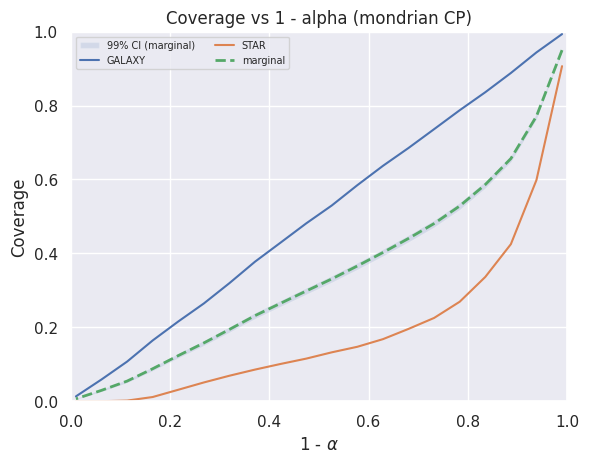

Generating set-size plot...


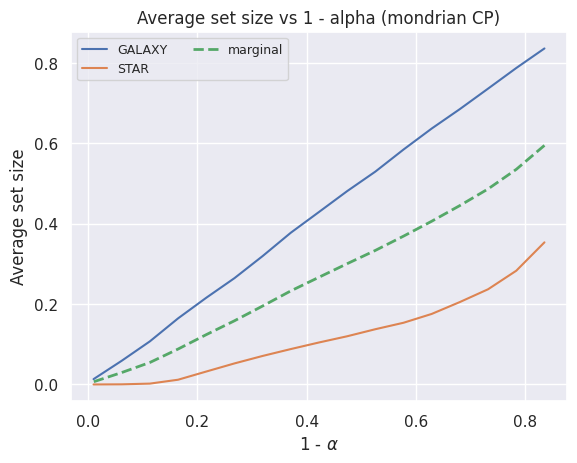

Generating ROC-style plot...


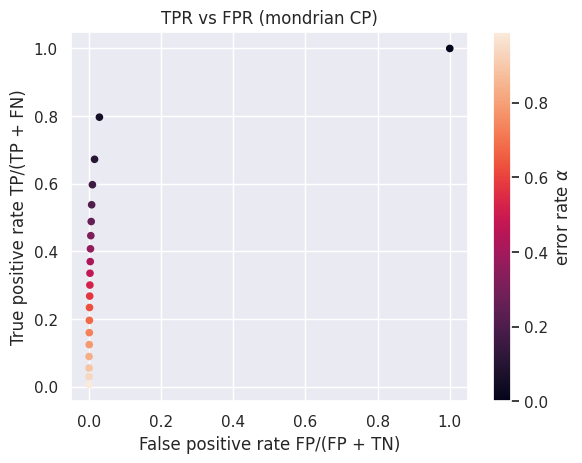

{'coverage_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_90/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_90/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_90/roc_mondrian.png'}

In [16]:

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.1,
    cutoff=3,
    save_dir="Trained_Models/Experiment3/SG/MargFormer/cp_plots_90",
    show_plots=True,
)


In [17]:
print(test_data.loc[0])
print('\n')
print(test_data.loc[1])
print('\n')
print(test_data.loc[4])
print('\n')
print(test_data.loc[5])


true_label        STAR
GALAXY        0.011914
STAR          0.988086
Name: 0, dtype: object


true_label      GALAXY
GALAXY        0.989331
STAR          0.010669
Name: 1, dtype: object


true_label        STAR
GALAXY        0.615413
STAR          0.384587
Name: 4, dtype: object


true_label      GALAXY
GALAXY        0.923358
STAR          0.076642
Name: 5, dtype: object


CP mode:          mondrian
Example alpha:    0.05
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.05:
  GALAXY: 0.135935
  STAR: 0.069470
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.05:
  Set size 0: 3180 / 19022 (16.72% of test points)
  Set size 1: 15842 / 19022 (83.28% of test points)

Examples with prediction set size = 0:
  Test index 4: true_label=STAR, argmax_pred=GALAXY, pred_set=[]
  Test index 7: true_label=STAR, argmax_pred=STAR, pred_set=[]

Examples with prediction set size = 1:
  Test index 0: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 1: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']
------------------------------------------------------------
Generating coverage plot...


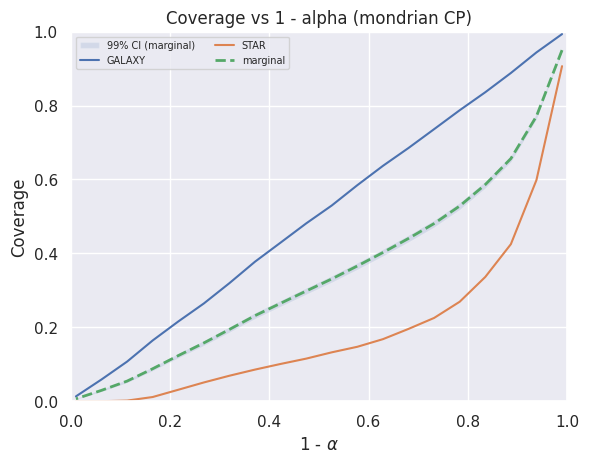

Generating set-size plot...


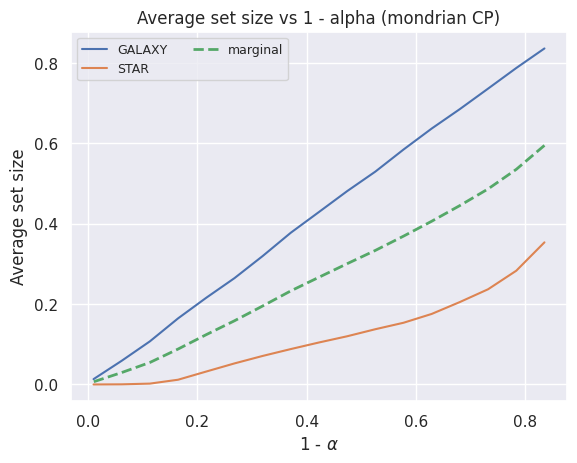

Generating ROC-style plot...


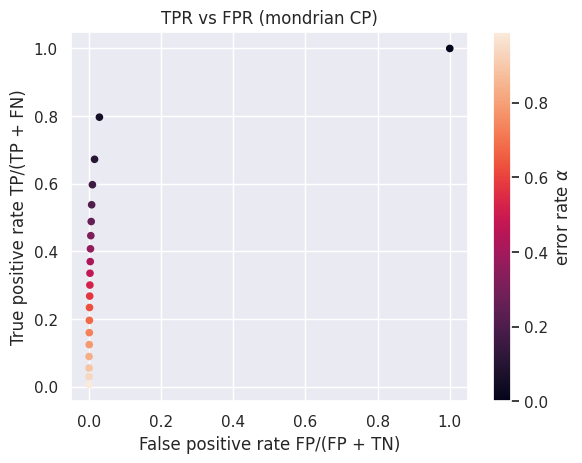

{'coverage_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_95/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_95/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_95/roc_mondrian.png'}

In [18]:

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.05,
    cutoff=3,
    save_dir="Trained_Models/Experiment3/SG/MargFormer/cp_plots_95",
    show_plots=True,
)


In [19]:
print(test_data.loc[0])
print('\n')
print(test_data.loc[1])
print('\n')
print(test_data.loc[4])
print('\n')
print(test_data.loc[7])


true_label        STAR
GALAXY        0.011914
STAR          0.988086
Name: 0, dtype: object


true_label      GALAXY
GALAXY        0.989331
STAR          0.010669
Name: 1, dtype: object


true_label        STAR
GALAXY        0.615413
STAR          0.384587
Name: 4, dtype: object


true_label        STAR
GALAXY        0.227127
STAR          0.772873
Name: 7, dtype: object


CP mode:          mondrian
Example alpha:    0.01
True label:        STAR
Argmax prediction: STAR
CP prediction set: ['STAR']
Set size:          1
------------------------------------------------------------
q_hat thresholds at alpha = 0.01:
  GALAXY: 0.788167
  STAR: 0.630241
------------------------------------------------------------
Set-size distribution on test data at alpha = 0.01:
  Set size 1: 17782 / 19022 (93.48% of test points)
  Set size 2: 1240 / 19022 (6.52% of test points)

Examples with prediction set size = 1:
  Test index 0: true_label=STAR, argmax_pred=STAR, pred_set=['STAR']
  Test index 1: true_label=GALAXY, argmax_pred=GALAXY, pred_set=['GALAXY']

Examples with prediction set size = 2:
  Test index 4: true_label=STAR, argmax_pred=GALAXY, pred_set=['GALAXY', 'STAR']
  Test index 7: true_label=STAR, argmax_pred=STAR, pred_set=['GALAXY', 'STAR']
------------------------------------------------------------
Generating coverage plot...


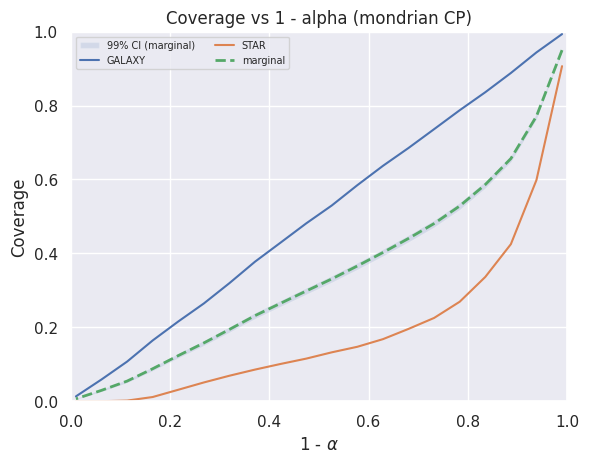

Generating set-size plot...


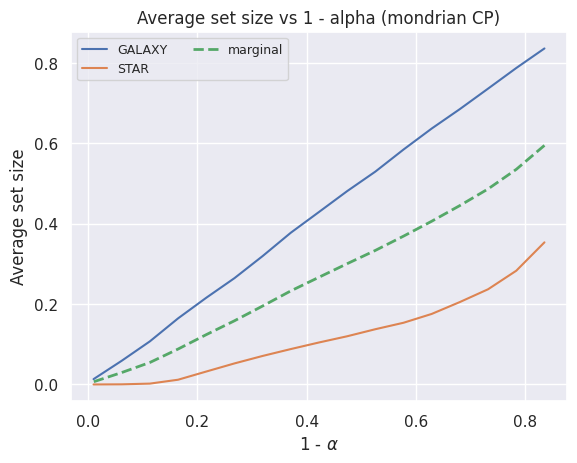

Generating ROC-style plot...


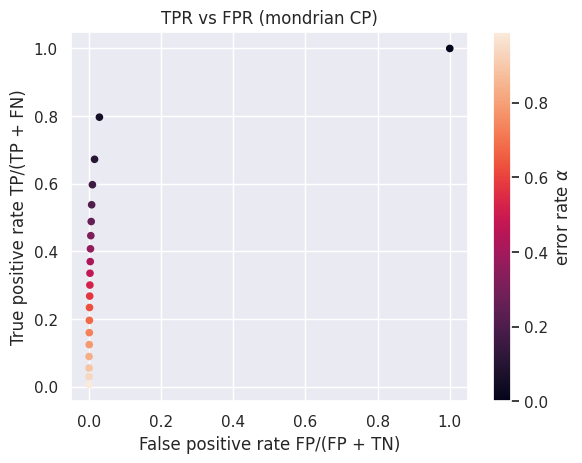

{'coverage_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_99/coverage_mondrian.png',
 'setsize_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_99/setsize_mondrian.png',
 'roc_path': 'Trained_Models/Experiment3/SG/MargFormer/cp_plots_99/roc_mondrian.png'}

In [20]:

# Run full analysis, save plots into 'cp_plots' folder
analyzer.run_full_analysis(
    example_alpha=0.01,
    cutoff=3,
    save_dir="Trained_Models/Experiment3/SG/MargFormer/cp_plots_99",
    show_plots=True,
)


In [21]:
print(test_data.loc[0])
print('\n')
print(test_data.loc[1])
print('\n')
print(test_data.loc[4])
print('\n')
print(test_data.loc[7])


true_label        STAR
GALAXY        0.011914
STAR          0.988086
Name: 0, dtype: object


true_label      GALAXY
GALAXY        0.989331
STAR          0.010669
Name: 1, dtype: object


true_label        STAR
GALAXY        0.615413
STAR          0.384587
Name: 4, dtype: object


true_label        STAR
GALAXY        0.227127
STAR          0.772873
Name: 7, dtype: object


In [22]:
df = pd.read_csv("/scratch/srinadb/Foundation/Dataset/Experiment3/photofeatures_exp3.csv")
df = df[df["class"].str.upper() != "QSO"].reset_index(drop=True)

r_mag_test = (df.loc[test_data.index, "dered_r"] + 
              df.loc[test_data.index, "extinction_r"]).to_numpy()


In [23]:
sns.set_palette("tab10")

def plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha: float = 0.1,
    r_min: float = 20.0,
    r_max: float = 23.0,
    bin_size: float = 0.1,
    min_per_bin: int = 50,
    save_path: str = None,
    show: bool = True,
):
    """
    Plot conformal coverage (y) vs r-magnitude (x) for a fixed alpha.

    Parameters
    ----------
    analyzer : ConformalCPAnalysis
        Fitted analyzer (after .fit()).
    r_mag_test : array-like, shape (n_samples,)
        r-magnitudes for the test set in the same order as analyzer.test_data.
    alpha : float
        Miscoverage level used in CP (e.g. 0.1 -> target coverage 0.9).
    r_min, r_max : float
        Range of r-magnitudes to consider.
    bin_size : float
        Bin width in magnitudes.
    min_per_bin : int
        Skip bins with fewer than this many examples.
    save_path : str or None
        If not None, save the plot to this path.
    show : bool
        If True, call plt.show(). If False, just return fig, ax.
    """
    # --- sanity ---
    r_mag_test = np.asarray(r_mag_test)
    if len(r_mag_test) != len(analyzer.test_data):
        raise ValueError("r_mag_test must have the same length as analyzer.test_data")

    # --- calibrate CP at this alpha ---
    qhat_dict = analyzer._calibrate(analyzer.calibration_data, alpha=alpha)

    # --- compute per-example coverage indicator ---
    covered = np.zeros(len(analyzer.test_data), dtype=bool)
    for i, (_, row) in enumerate(analyzer.test_data.iterrows()):
        pred_set = analyzer._predict_set(row, qhat_dict)
        covered[i] = (row["true_label"] in pred_set)

    # --- bin in r magnitude ---
    lower_bins = np.arange(r_min, r_max, bin_size)
    centers = lower_bins + bin_size / 2

    covs = []
    n_points = []
    ci_low = []
    ci_high = []

    for lb in lower_bins:
        mask = (r_mag_test > lb) & (r_mag_test <= lb + bin_size)
        n_bin = mask.sum()
        n_points.append(n_bin)

        if n_bin < min_per_bin:
            covs.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        n_cov = covered[mask].sum()
        cov = n_cov / n_bin

        # binomial confidence interval for coverage
        low, high = proportion_confint(n_cov, n_bin, alpha=0.05, method="beta")

        covs.append(cov)
        ci_low.append(low)
        ci_high.append(high)

    covs = np.array(covs)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    # --- plot ---
    fig, ax = plt.subplots()

    # Only plot bins with enough points
    valid = ~np.isnan(covs)
    x = centers[valid]
    y = covs[valid]
    yerr_lower = y - ci_low[valid]
    yerr_upper = ci_high[valid] - y

    ax.errorbar(
        x,
        y,
        xerr=bin_size / 2,
        yerr=[yerr_lower, yerr_upper],
        fmt="o",
        capsize=2,
        label="Empirical coverage",
    )

    # expected coverage line
    ax.axhline(1 - alpha, linestyle="--", label=fr"Target $1-\alpha={1-alpha:.2f}$")

    ax.set_xlabel("r magnitude")
    ax.set_ylabel("Coverage")
    ax.set_ylim(0, 1.05)
    ax.set_title(f"Conformal coverage vs r magnitude (α={alpha:.2f}, {analyzer.cp_mode} CP)")
    ax.grid(True)
    ax.legend()

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax, {
        "bin_centers": centers,
        "coverage": covs,
        "n_points": np.array(n_points),
        "ci_low": ci_low,
        "ci_high": ci_high,
    }


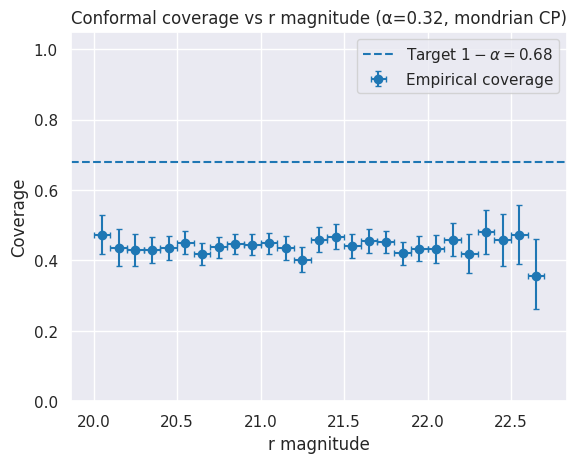

In [24]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.32,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment3/SG/MargFormer/cp_plots_68/coverage_vs_rmag.png",
    show=True,
)


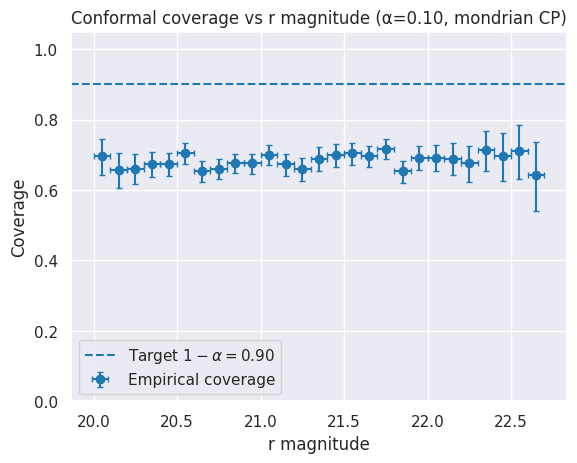

In [25]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.1,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment3/SG/MargFormer/cp_plots_90/coverage_vs_rmag.png",
    show=True,
)


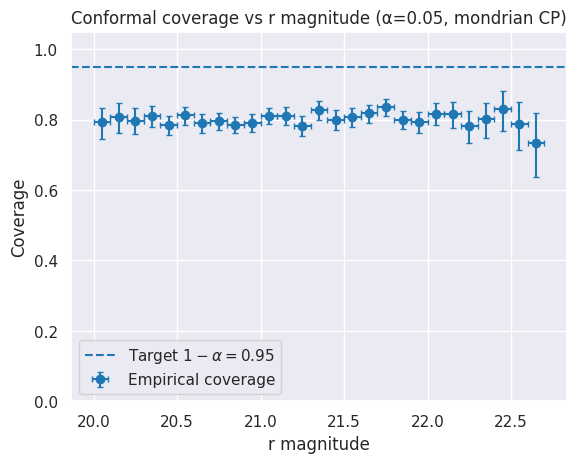

In [26]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.05,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment3/SG/MargFormer/cp_plots_95/coverage_vs_rmag.png",
    show=True,
)


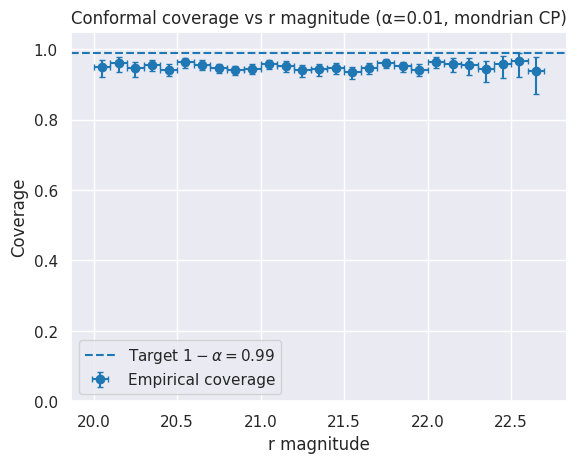

In [27]:
# Plot coverage vs r magnitude at alpha=0.1
fig, ax, stats = plot_cp_coverage_vs_rmag(
    analyzer,
    r_mag_test,
    alpha=0.01,
    r_min=20.0,
    r_max=23.0,
    bin_size=0.1,
    min_per_bin=50,
    save_path="Trained_Models/Experiment3/SG/MargFormer/cp_plots_99/coverage_vs_rmag.png",
    show=True,
)
